# PROYECTO FINAL - MACHINE LEARNING 
# PREDICCIÓN DE ARRIBOS DE BICICLETAS PÚBLICAS GCBA

In [23]:
%load_ext autoreload
%autoreload 2

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# Para el modelado
from sklearn.model_selection import train_test_split, TimeSeriesSplit
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [25]:
torch.cuda.is_available()

True

PASO 1: CARGA Y EXPLORACIÓN INICIAL DE DATOS

In [26]:
print("🚴 CARGANDO DATOS DE BICICLETAS PÚBLICAS BA...")

# Cargar datos de trips 2024
trips_df = pd.read_csv('data/raw/trips_2024.csv')
usuarios_df = pd.read_csv('data/raw/usuarios_ecobici_2024.csv')

print(f"📊 Datos cargados:")
print(f"   - Trips: {trips_df.shape[0]:,} registros, {trips_df.shape[1]} columnas")
print(f"   - Usuarios: {usuarios_df.shape[0]:,} registros, {usuarios_df.shape[1]} columnas")

🚴 CARGANDO DATOS DE BICICLETAS PÚBLICAS BA...
📊 Datos cargados:
   - Trips: 3,559,284 registros, 17 columnas
   - Usuarios: 197,077 registros, 5 columnas


In [27]:

print("\n🔍 EXPLORANDO ESTRUCTURA DE TRIPS...")
print(f"Columnas de trips: {list(trips_df.columns)}")
print(f"\nPrimeras filas:")
print(trips_df.head())

print(f"\nInfo de trips:")
print(trips_df.info())

print("\n🔍 EXPLORANDO ESTRUCTURA DE USUARIOS...")
print(f"Columnas de usuarios: {list(usuarios_df.columns)}")
print(f"\nPrimeras filas:")
print(usuarios_df.head())


🔍 EXPLORANDO ESTRUCTURA DE TRIPS...
Columnas de trips: ['id_recorrido', 'duracion_recorrido', 'fecha_origen_recorrido', 'id_estacion_origen', 'nombre_estacion_origen', 'direccion_estacion_origen', 'long_estacion_origen', 'lat_estacion_origen', 'fecha_destino_recorrido', 'id_estacion_destino', 'nombre_estacion_destino', 'direccion_estacion_destino', 'long_estacion_destino', 'lat_estacion_destino', 'id_usuario', 'modelo_bicicleta', 'genero']

Primeras filas:
   id_recorrido  duracion_recorrido fecha_origen_recorrido  \
0      20428222                 568    2024-01-23 18:36:00   
1      20431744                1355    2024-01-23 22:41:20   
2      20429936                   0    2024-01-23 20:06:22   
3      20429976                   0    2024-01-23 20:08:17   
4      20424802                 680    2024-01-23 15:18:39   

   id_estacion_origen  nombre_estacion_origen direccion_estacion_origen  \
0                 513     308 - SAN MARTIN II       Av. San Martín 5129   
1              

PASO 2: PREPROCESAMIENTO DE DATOS

In [28]:
print("\n🛠️ PREPROCESANDO DATOS...")

# Convertir fechas a datetime
trips_df['fecha_origen_recorrido'] = pd.to_datetime(trips_df['fecha_origen_recorrido'])
trips_df['fecha_destino_recorrido'] = pd.to_datetime(trips_df['fecha_destino_recorrido'])

# Filtrar solo datos hasta agosto 2024 como especifica el enunciado
trips_df = trips_df[trips_df['fecha_origen_recorrido'] <= '2024-08-31']

print(f"📅 Datos filtrados hasta agosto 2024: {trips_df.shape[0]:,} registros")

# Verificar rango de fechas
print(f"   - Fecha mínima: {trips_df['fecha_origen_recorrido'].min()}")
print(f"   - Fecha máxima: {trips_df['fecha_origen_recorrido'].max()}")


🛠️ PREPROCESANDO DATOS...
📅 Datos filtrados hasta agosto 2024: 2,155,229 registros
   - Fecha mínima: 2024-01-01 00:06:50
   - Fecha máxima: 2024-08-30 23:57:59


In [29]:

print("\n📈 ANÁLISIS EXPLORATORIO...")

# Estadísticas básicas de duración
print(f"Duración promedio de viajes: {trips_df['duracion_recorrido'].mean():.2f} segundos")
print(f"Duración mediana: {trips_df['duracion_recorrido'].median():.2f} segundos")

# Cantidad de estaciones únicas
n_estaciones_origen = trips_df['id_estacion_origen'].nunique()
n_estaciones_destino = trips_df['id_estacion_destino'].nunique()
print(f"Estaciones origen únicas: {n_estaciones_origen}")
print(f"Estaciones destino únicas: {n_estaciones_destino}")


📈 ANÁLISIS EXPLORATORIO...
Duración promedio de viajes: 1303.73 segundos
Duración mediana: 872.00 segundos
Estaciones origen únicas: 374
Estaciones destino únicas: 376


PASO 3: FEATURE ENGINEERING - CREACIÓN DE VENTANAS TEMPORALES

In [30]:

print("\n⚙️ CREANDO FEATURES TEMPORALES...")

# Definir delta T (usaremos 30 minutos como ejemplo)
DELTA_T_MINUTES = 30

# Agregar features temporales
trips_df['año'] = trips_df['fecha_origen_recorrido'].dt.year
trips_df['mes'] = trips_df['fecha_origen_recorrido'].dt.month
trips_df['dia'] = trips_df['fecha_origen_recorrido'].dt.day
trips_df['hora'] = trips_df['fecha_origen_recorrido'].dt.hour
trips_df['dia_semana'] = trips_df['fecha_origen_recorrido'].dt.dayofweek
trips_df['es_fin_de_semana'] = trips_df['dia_semana'].isin([5, 6]).astype(int)

# Crear ventanas temporales de 30 minutos
trips_df['timestamp_rounded'] = trips_df['fecha_origen_recorrido'].dt.floor(f'{DELTA_T_MINUTES}min')

print(f"✅ Features temporales creadas con ventanas de {DELTA_T_MINUTES} minutos")



⚙️ CREANDO FEATURES TEMPORALES...
✅ Features temporales creadas con ventanas de 30 minutos


In [31]:
# guardar trips_df 
trips_df.to_csv('data/processed/trips_2024_preprocessed.csv', index=False)

KeyboardInterrupt: 

PASO 4: CREACIÓN DEL DATASET PARA ML - AGREGACIÓN POR VENTANAS

In [32]:
print("\n🎯 CREANDO DATASET PARA MACHINE LEARNING...")

# Obtener lista de todas las estaciones
todas_las_estaciones = pd.concat([
    trips_df[['id_estacion_origen', 'nombre_estacion_origen', 'lat_estacion_origen', 'long_estacion_origen']].rename(columns={
        'id_estacion_origen': 'id_estacion',
        'nombre_estacion_origen': 'nombre_estacion', 
        'lat_estacion_origen': 'lat_estacion',
        'long_estacion_origen': 'long_estacion'
    }),
    trips_df[['id_estacion_destino', 'nombre_estacion_destino', 'lat_estacion_destino', 'long_estacion_destino']].rename(columns={
        'id_estacion_destino': 'id_estacion',
        'nombre_estacion_destino': 'nombre_estacion',
        'lat_estacion_destino': 'lat_estacion', 
        'long_estacion_destino': 'long_estacion'
    })
]).drop_duplicates(subset=['id_estacion'])

print(f"📍 Total de estaciones identificadas: {len(todas_las_estaciones)}")


🎯 CREANDO DATASET PARA MACHINE LEARNING...
📍 Total de estaciones identificadas: 376


In [33]:

print("\n📤 AGREGANDO PARTIDAS POR VENTANA TEMPORAL...")

# Contar partidas por estación y ventana temporal
partidas_por_ventana = (trips_df.groupby(['timestamp_rounded', 'id_estacion_origen'])
                       .agg({
                           'id_recorrido': 'count',
                           'hora': 'first',
                           'dia_semana': 'first', 
                           'es_fin_de_semana': 'first',
                           'mes': 'first',
                           'dia': 'first'
                       })
                       .rename(columns={'id_recorrido': 'partidas'})
                       .reset_index())

print(f"✅ Partidas agregadas: {len(partidas_por_ventana)} registros")


📤 AGREGANDO PARTIDAS POR VENTANA TEMPORAL...
✅ Partidas agregadas: 1146667 registros


In [34]:

print("\n📥 AGREGANDO ARRIBOS POR VENTANA TEMPORAL...")
# Para los arribos, necesitamos usar la fecha de destino
trips_df['timestamp_destino_rounded'] = trips_df['fecha_destino_recorrido'].dt.floor(f'{DELTA_T_MINUTES}min')

# Contar arribos por estación y ventana temporal
arribos_por_ventana = (trips_df.groupby(['timestamp_destino_rounded', 'id_estacion_destino'])
                      .agg({
                          'id_recorrido': 'count'
                      })
                      .rename(columns={'id_recorrido': 'arribos'})
                      .reset_index()
                      .rename(columns={'timestamp_destino_rounded': 'timestamp_rounded',
                                     'id_estacion_destino': 'id_estacion'}))

print(f"✅ Arribos agregados: {len(arribos_por_ventana)} registros")
trips_df


📥 AGREGANDO ARRIBOS POR VENTANA TEMPORAL...
✅ Arribos agregados: 1204063 registros


,id_recorrido,duracion_recorrido,fecha_origen_recorrido,id_estacion_origen,nombre_estacion_origen,direccion_estacion_origen,long_estacion_origen,lat_estacion_origen,fecha_destino_recorrido,id_estacion_destino,...,modelo_bicicleta,genero,año,mes,dia,hora,dia_semana,es_fin_de_semana,timestamp_rounded,timestamp_destino_rounded
0,20428222,568,2024-01-23 18:36:00,513,308 - SAN MARTIN II,Av. San Martín 5129,-58.490739,-34.597130,2024-01-23 18:45:28,498,...,FIT,MALE,2024,1,23,18,1,0,2024-01-23 18:30:00,2024-01-23 18:30:00
1,20431744,1355,2024-01-23 22:41:20,460,133 - BEIRO Y SEGUROLA,Segurola 3194,-58.511930,-34.607500,2024-01-23 23:03:55,382,...,FIT,FEMALE,2024,1,23,22,1,0,2024-01-23 22:30:00,2024-01-23 23:00:00
2,20429936,0,2024-01-23 20:06:22,467,328 - SARMIENTO II,Sarmiento 2037,-58.395893,-34.605514,2024-01-23 20:06:22,6,...,FIT,FEMALE,2024,1,23,20,1,0,2024-01-23 20:00:00,2024-01-23 20:00:00
3,20429976,0,2024-01-23 20:08:17,382,204 - Biarritz,Biarritz 2403,-58.477255,-34.605431,2024-01-23 20:08:17,460,...,ICONIC,FEMALE,2024,1,23,20,1,0,2024-01-23 20:00:00,2024-01-23 20:00:00
4,20424802,680,2024-01-23 15:18:39,137,137 - AZOPARDO Y CHILE,AZOPARDO 700,-58.367492,-34.615598,2024-01-23 15:29:59,150,...,FIT,FEMALE,2024,1,23,15,1,0,2024-01-23 15:00:00,2024-01-23 15:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3559279,21526830,506,2024-04-25 21:35:33,93,093 - CARLOS CALVO,Sarandi 1010,-58.394464,-34.620798,2024-04-25 21:43:59,175,...,ICONIC,MALE,2024,4,25,21,3,0,2024-04-25 21:30:00,2024-04-25 21:30:00
3559280,21525192,970,2024-04-25 17:34:30,137,137 - AZOPARDO Y CHILE,AZOPARDO 700,-58.367492,-34.615598,2024-04-25 17:50:40,93,...,FIT,MALE,2024,4,25,17,3,0,2024-04-25 17:30:00,2024-04-25 17:30:00
3559281,21525370,1442,2024-04-25 17:45:12,263,270 - PLAZA DEL ANGEL GRIS,Calcena & Avellaneda Av.,-58.457555,-34.622003,2024-04-25 18:09:14,263,...,FIT,MALE,2024,4,25,17,3,0,2024-04-25 17:30:00,2024-04-25 18:00:00
3559282,21526289,520,2024-04-25 19:28:49,222,160 - Godoy Cruz y Libertador,Av. Cerviño 4301,-58.418543,-34.575919,2024-04-25 19:37:29,124,...,ICONIC,FEMALE,2024,4,25,19,3,0,2024-04-25 19:00:00,2024-04-25 19:30:00


PASO 5: CREACIÓN DE FEATURES Y TARGETS 

In [35]:

print("\n🎯 CREANDO FEATURES (X) Y TARGETS (Y)...")

# Obtener todas las combinaciones de timestamp y estación posibles
timestamps_unicos = pd.date_range(
    start=trips_df['timestamp_rounded'].min(),
    end=trips_df['timestamp_rounded'].max(), 
    freq=f'{DELTA_T_MINUTES}min'
)

# Crear un DataFrame base con todas las combinaciones
base_df = pd.DataFrame([
    (ts, estacion) 
    for ts in timestamps_unicos 
    for estacion in todas_las_estaciones['id_estacion'].unique()
], columns=['timestamp', 'id_estacion'])

print(f"📊 Dataset base creado: {len(base_df)} registros")
print(f"   - Ventanas temporales: {len(timestamps_unicos)}")
print(f"   - Estaciones: {todas_las_estaciones['id_estacion'].nunique()}")


🎯 CREANDO FEATURES (X) Y TARGETS (Y)...
📊 Dataset base creado: 4385664 registros
   - Ventanas temporales: 11664
   - Estaciones: 376


In [36]:

print("\n🔗 COMBINANDO PARTIDAS Y ARRIBOS...")

# Merge con partidas
dataset = base_df.merge(
    partidas_por_ventana.rename(columns={'timestamp_rounded': 'timestamp', 'id_estacion_origen': 'id_estacion'}),
    on=['timestamp', 'id_estacion'], 
    how='left'
)

# Merge con arribos (estos serán nuestros targets futuros)
dataset = dataset.merge(
    arribos_por_ventana.rename(columns={'timestamp_rounded': 'timestamp'}),
    on=['timestamp', 'id_estacion'],
    how='left'
)

# Rellenar NaN con 0 (no hubo partidas/arribos)
dataset['partidas'] = dataset['partidas'].fillna(0)
dataset['arribos'] = dataset['arribos'].fillna(0)

print(f"✅ Dataset combinado: {len(dataset)} registros")


🔗 COMBINANDO PARTIDAS Y ARRIBOS...
✅ Dataset combinado: 4385664 registros


In [37]:

print("\n📍 AGREGANDO INFORMACIÓN GEOGRÁFICA...")

dataset = dataset.merge(
    todas_las_estaciones[['id_estacion', 'lat_estacion', 'long_estacion', 'nombre_estacion']],
    on='id_estacion',
    how='left'
)

# Agregar features temporales al dataset final
dataset['hora'] = dataset['timestamp'].dt.hour
dataset['dia_semana'] = dataset['timestamp'].dt.dayofweek  
dataset['es_fin_de_semana'] = dataset['dia_semana'].isin([5, 6]).astype(int)
dataset['mes'] = dataset['timestamp'].dt.month
dataset['dia'] = dataset['timestamp'].dt.day

print(f"✅ Features geográficas y temporales agregadas")


📍 AGREGANDO INFORMACIÓN GEOGRÁFICA...
✅ Features geográficas y temporales agregadas


 PASO 6: CREACIÓN DE FEATURES DE PARTIDAS PASADAS PARA PREDICCIÓN

In [38]:

print("\n⏰ CREANDO FEATURES DE PARTIDAS PASADAS...")

# Ordenar por timestamp para crear las features de lag
dataset = dataset.sort_values(['id_estacion', 'timestamp'])

# Crear features de lag (partidas en ventanas anteriores)
for lag in [1, 2, 3, 6]:  # 1, 2, 3 y 6 ventanas atrás (30, 60, 90, 180 mins)
    dataset[f'partidas_lag_{lag}'] = dataset.groupby('id_estacion')['partidas'].shift(lag)

# Features agregadas de partidas pasadas
dataset['partidas_rolling_mean_3'] = dataset.groupby('id_estacion')['partidas'].rolling(window=3, min_periods=1).mean().values
dataset['partidas_rolling_sum_6'] = dataset.groupby('id_estacion')['partidas'].rolling(window=6, min_periods=1).sum().values

print(f"✅ Features de lag creadas")


⏰ CREANDO FEATURES DE PARTIDAS PASADAS...
✅ Features de lag creadas


PASO 7: CREACIÓN DE TARGETS FUTUROS

In [39]:

print("\n🎯 CREANDO TARGETS FUTUROS...")

# Crear targets futuros (arribos en las próximas ventanas)
dataset['arribos_futuro_1'] = dataset.groupby('id_estacion')['arribos'].shift(-1)  # Próximos 30 min
dataset['arribos_futuro_2'] = dataset.groupby('id_estacion')['arribos'].shift(-2)  # Próximos 60 min

# Target principal: arribos en los próximos 30 minutos
dataset['target'] = dataset['arribos_futuro_1']

print(f"✅ Targets futuros creados")
dataset


🎯 CREANDO TARGETS FUTUROS...
✅ Targets futuros creados


,timestamp,id_estacion,partidas,hora,dia_semana,es_fin_de_semana,mes,dia,arribos,lat_estacion,...,nombre_estacion,partidas_lag_1,partidas_lag_2,partidas_lag_3,partidas_lag_6,partidas_rolling_mean_3,partidas_rolling_sum_6,arribos_futuro_1,arribos_futuro_2,target
74,2024-01-01 00:00:00,2,0.0,0,0,0,1,1,0.0,-34.592424,...,002 - Retiro I,NaN,NaN,NaN,NaN,0.000000,0.0,0.0,0.0,0.0
450,2024-01-01 00:30:00,2,0.0,0,0,0,1,1,0.0,-34.592424,...,002 - Retiro I,0.0,NaN,NaN,NaN,0.000000,0.0,0.0,0.0,0.0
826,2024-01-01 01:00:00,2,0.0,1,0,0,1,1,0.0,-34.592424,...,002 - Retiro I,0.0,0.0,NaN,NaN,0.000000,0.0,0.0,0.0,0.0
1202,2024-01-01 01:30:00,2,0.0,1,0,0,1,1,0.0,-34.592424,...,002 - Retiro I,0.0,0.0,0.0,NaN,0.000000,0.0,0.0,0.0,0.0
1578,2024-01-01 02:00:00,2,0.0,2,0,0,1,1,0.0,-34.592424,...,002 - Retiro I,0.0,0.0,0.0,NaN,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4384152,2024-08-30 21:30:00,556,0.0,21,4,0,8,30,0.0,-34.583613,...,230 - AREVALO,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4384528,2024-08-30 22:00:00,556,1.0,22,4,0,8,30,0.0,-34.583613,...,230 - AREVALO,0.0,0.0,0.0,0.0,0.333333,1.0,0.0,0.0,0.0
4384904,2024-08-30 22:30:00,556,0.0,22,4,0,8,30,0.0,-34.583613,...,230 - AREVALO,1.0,0.0,0.0,0.0,0.333333,1.0,0.0,0.0,0.0
4385280,2024-08-30 23:00:00,556,0.0,23,4,0,8,30,0.0,-34.583613,...,230 - AREVALO,0.0,1.0,0.0,0.0,0.333333,1.0,0.0,NaN,0.0


PASO 8: FEATURE ENGINEERING ADICIONAL

In [40]:
# reemplazar todos los Nan por 0
dataset = dataset.fillna(0)

# Agregar información de usuarios si está disponible
if not usuarios_df.empty:
    # Obtener estadísticas de usuarios por viaje
    user_stats = trips_df.groupby(['timestamp_rounded', 'id_estacion_origen'])['id_usuario'].agg(['count', 'nunique']).reset_index()
    user_stats.columns = ['timestamp', 'id_estacion', 'total_viajes_usuarios', 'usuarios_unicos']
    
    dataset = dataset.merge(user_stats, on=['timestamp', 'id_estacion'], how='left')
    dataset['total_viajes_usuarios'] = dataset['total_viajes_usuarios'].fillna(0)
    dataset['usuarios_unicos'] = dataset['usuarios_unicos'].fillna(0)
    
    print(f"✅ Features de usuarios agregadas")

# Features de ubicación relativa
if not dataset.empty:
    centro_lat = dataset['lat_estacion'].mean()
    centro_long = dataset['long_estacion'].mean()
    
    dataset['distancia_al_centro'] = np.sqrt(
        (dataset['lat_estacion'] - centro_lat)**2 + 
        (dataset['long_estacion'] - centro_long)**2
    )
    
    print(f"✅ Features de ubicación relativa agregadas")

dataset["hora_sin"] = np.sin(2 * np.pi * dataset["hora"] / 24)
dataset["hora_cos"] = np.cos(2 * np.pi * dataset["hora"] / 24)


✅ Features de usuarios agregadas
✅ Features de ubicación relativa agregadas


In [ ]:
# from sklearn.neighbors import BallTree
# from geopy.distance import geodesic

# # Convertir lat/lon a radianes para BallTree
# latlon = np.deg2rad(dataset[['lat_estacion', 'long_estacion']].drop_duplicates().values)
# tree = BallTree(latlon, metric='haversine')

# # Mapping id_estacion -> (lat, lon)
# # Coordenadas únicas de estaciones (ordenadas por id_estacion)
# est_coords = dataset[['id_estacion', 'lat_estacion', 'long_estacion']].drop_duplicates().sort_values("id_estacion")
# ids = est_coords['id_estacion'].tolist()

# # Coordenadas en radianes con mismo orden
# latlon_unique = np.deg2rad(est_coords[['lat_estacion', 'long_estacion']].values)

# # BallTree
# tree = BallTree(latlon_unique, metric='haversine')

# # Mapear índice -> id_estacion
# index_to_id = {i: est_id for i, est_id in enumerate(ids)}

# # Cache de vecinos
# vecinos_por_estacion = {}
# for i, est_id in enumerate(ids):
#     _, indices = tree.query_radius([latlon_unique[i]], r=0.5 / 6371, return_distance=True)
#     vecinos = [index_to_id[int(j)] for j in indices[0] if index_to_id[int(j)] != est_id]
#     vecinos_por_estacion[est_id] = vecinos


# # Agrupar por timestamp para evitar escanear toda la tabla cada vez
# print("⚙️ Precalculando features vecinales por timestamp...")
# resultados = []
# from tqdm import tqdm

# for timestamp, group in tqdm(dataset.groupby("timestamp"), total=11500):

#     # Crear diccionario de partidas por estación
#     partidas_por_estacion = group.set_index("id_estacion")["partidas"].to_dict()

#     for _, row in group.iterrows():
#         est_id = row["id_estacion"]
#         vecinos = vecinos_por_estacion.get(est_id, [])
#         partidas_vecinas = [partidas_por_estacion.get(vid, 0) for vid in vecinos]
        
#         suma = sum(partidas_vecinas)
#         prom = np.mean(partidas_vecinas) if partidas_vecinas else 0
#         activas = sum(p > 0 for p in partidas_vecinas)

#         resultados.append({
#             'index': row.name,
#             'partidas_vecinas_500m': suma,
#             'promedio_partidas_vecinas_500m': prom,
#             'estaciones_activas_500m': activas
#         })

# # Merge final
# regional_df = pd.DataFrame(resultados).set_index('index')
# dataset = dataset.join(regional_df)

⚙️ Precalculando features vecinales por timestamp...


11664it [04:26, 43.81it/s]                           


PASO 9: PREPARACIÓN DE DATOS PARA MODELADO

In [41]:

print("\n🎓 PREPARANDO DATOS PARA MODELADO...")

# Seleccionar features para el modelo
feature_columns = [
    'id_estacion','hora', 'dia_semana', 'es_fin_de_semana', 'mes', 'dia',
    'lat_estacion', 'long_estacion', 'distancia_al_centro',
    'partidas', 'partidas_lag_1', 'partidas_lag_2', 'partidas_lag_3', 'partidas_lag_6',
    'partidas_rolling_mean_3', 'partidas_rolling_sum_6', 'hora_sin', 'hora_cos'
]

# Agregar features de usuario si existen
if 'total_viajes_usuarios' in dataset.columns:
    feature_columns.extend(['total_viajes_usuarios', 'usuarios_unicos'])

# Filtrar registros válidos (sin NaN en target y con suficientes lags)
dataset_clean = dataset.dropna(subset=['target'] + feature_columns)

print(f"📊 Dataset limpio: {len(dataset_clean)} registros")
print(f"📊 Features seleccionadas: {len(feature_columns)}")
dataset_clean


🎓 PREPARANDO DATOS PARA MODELADO...
📊 Dataset limpio: 4385664 registros
📊 Features seleccionadas: 20


,timestamp,id_estacion,partidas,hora,dia_semana,es_fin_de_semana,mes,dia,arribos,lat_estacion,...,partidas_rolling_mean_3,partidas_rolling_sum_6,arribos_futuro_1,arribos_futuro_2,target,total_viajes_usuarios,usuarios_unicos,distancia_al_centro,hora_sin,hora_cos
0,2024-01-01 00:00:00,2,0.0,0,0,0,1,1,0.0,-34.592424,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.062708,0.000000,1.000000
1,2024-01-01 00:30:00,2,0.0,0,0,0,1,1,0.0,-34.592424,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.062708,0.000000,1.000000
2,2024-01-01 01:00:00,2,0.0,1,0,0,1,1,0.0,-34.592424,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.062708,0.258819,0.965926
3,2024-01-01 01:30:00,2,0.0,1,0,0,1,1,0.0,-34.592424,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.062708,0.258819,0.965926
4,2024-01-01 02:00:00,2,0.0,2,0,0,1,1,0.0,-34.592424,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.062708,0.500000,0.866025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4385659,2024-08-30 21:30:00,556,0.0,21,4,0,8,30,0.0,-34.583613,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.017981,-0.707107,0.707107
4385660,2024-08-30 22:00:00,556,1.0,22,4,0,8,30,0.0,-34.583613,...,0.333333,1.0,0.0,0.0,0.0,1.0,1.0,0.017981,-0.500000,0.866025
4385661,2024-08-30 22:30:00,556,0.0,22,4,0,8,30,0.0,-34.583613,...,0.333333,1.0,0.0,0.0,0.0,0.0,0.0,0.017981,-0.500000,0.866025
4385662,2024-08-30 23:00:00,556,0.0,23,4,0,8,30,0.0,-34.583613,...,0.333333,1.0,0.0,0.0,0.0,0.0,0.0,0.017981,-0.258819,0.965926


In [42]:

print("\n📈 ANÁLISIS DE DISTRIBUCIÓN DE TARGETS...")

print(f"Estadísticas de arribos futuros:")
print(f"   - Media: {dataset_clean['target'].mean():.2f}")
print(f"   - Desviación estándar: {dataset_clean['target'].std():.2f}")
print(f"   - Máximo: {dataset_clean['target'].max()}")


📈 ANÁLISIS DE DISTRIBUCIÓN DE TARGETS...
Estadísticas de arribos futuros:
   - Media: 0.49
   - Desviación estándar: 1.06
   - Máximo: 31.0


PASO 10: SPLIT TEMPORAL DE DATOS

In [89]:

print("\n✂️ DIVIDIENDO DATOS TEMPORALMENTE...")

# Split temporal: últimas 2 semanas para test
cutoff_date = dataset_clean['timestamp'].max() - timedelta(weeks=8)

train_data = dataset_clean[dataset_clean['timestamp'] <= cutoff_date]
test_data = dataset_clean[dataset_clean['timestamp'] > cutoff_date]

print(f"📅 Split temporal:")
print(f"   - Train: {len(train_data)} registros (hasta {cutoff_date.strftime('%Y-%m-%d')})")
print(f"   - Test: {len(test_data)} registros (desde {cutoff_date.strftime('%Y-%m-%d')})")

# Preparar X y y
X_train = train_data[feature_columns]
y_train = train_data['target']
X_test = test_data[feature_columns]
y_test = test_data['target']

print(f"✅ Datos preparados para entrenamiento")


✂️ DIVIDIENDO DATOS TEMPORALMENTE...
📅 Split temporal:
   - Train: 3374976 registros (hasta 2024-07-05)
   - Test: 1010688 registros (desde 2024-07-05)
✅ Datos preparados para entrenamiento


PASO 11: ESCALADO DE FEATURES

In [44]:
print("\n📏 ESCALANDO FEATURES...")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"✅ Features escaladas")


📏 ESCALANDO FEATURES...
✅ Features escaladas


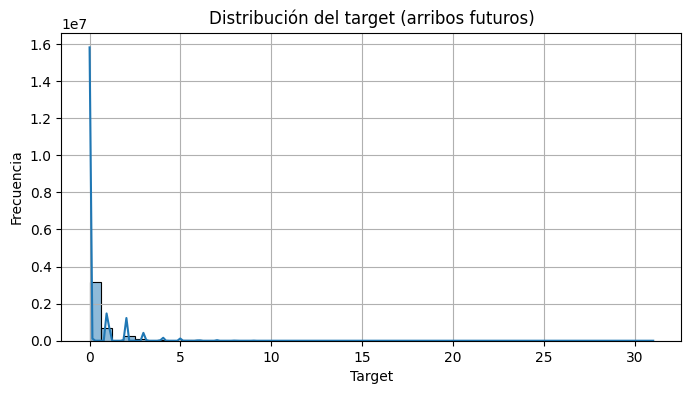

In [47]:
plt.figure(figsize=(8, 4))
sns.histplot(dataset["target"], bins=50, kde=True)
plt.title("Distribución del target (arribos futuros)")
plt.xlabel("Target")
plt.ylabel("Frecuencia")
plt.grid(True)
plt.show()


In [ ]:
dataset_clean.to_csv('data/streamlit/dataset_sample.csv', index=False)

In [92]:
print("\n🚴 ENTRENANDO MLP CON EMBEDDINGS PARA ESTACIONES...")

# ===================== 🔧 PREPROCESAMIENTO =====================

print("\n✂️ DIVIDIENDO DATOS TEMPORALMENTE...")

# Crear índice entero único para cada estación
station_mapping = {sid: idx for idx, sid in enumerate(dataset_clean['id_estacion'].unique())}
dataset_clean['station_index'] = dataset_clean['id_estacion'].map(station_mapping)

# Split temporal: últimas 8 semanas para test
cutoff_date = dataset_clean['timestamp'].max() - timedelta(weeks=8)

train_data = dataset_clean[dataset_clean['timestamp'] <= cutoff_date].copy()
test_data = dataset_clean[dataset_clean['timestamp'] > cutoff_date].copy()

print(f"📅 Split temporal:")
print(f"   - Train: {len(train_data)} registros (hasta {cutoff_date.strftime('%Y-%m-%d')})")
print(f"   - Test: {len(test_data)} registros (desde {cutoff_date.strftime('%Y-%m-%d')})")

# Separar features y targets
feature_columns = ['id_estacion','hora', 'dia_semana', 'es_fin_de_semana', 'mes', 'dia',
    'lat_estacion', 'long_estacion', 'distancia_al_centro',
    'partidas', 'partidas_lag_1', 'partidas_lag_2', 'partidas_lag_3', 'partidas_lag_6',
    'partidas_rolling_mean_3', 'partidas_rolling_sum_6', 'hora_sin', 'hora_cos'
]

X_train = train_data[feature_columns]
y_train_np = train_data['target']
station_train = train_data['station_index'].values

X_test = test_data[feature_columns]
y_test_np = test_data['target']
station_test = test_data['station_index'].values

print(f"✅ Datos preparados para entrenamiento con station_index incluido.")

print(X_train.columns)

# Columnas categóricas y numéricas
categorical_cols = ['hora', 'dia_semana', 'mes']
numerical_cols = [col for col in X_train.columns if col not in categorical_cols]

# ColumnTransformer (OneHot + StandardScaler)
preprocessor = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
    ('num', StandardScaler(), numerical_cols)
])

# Aplicar transformación
X_train_proc = preprocessor.fit_transform(X_train)
X_test_proc = preprocessor.transform(X_test)

# Convertir a tensores
X_train_tensor = torch.tensor(X_train_proc, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_proc, dtype=torch.float32)


station_train_tensor = torch.tensor(station_train, dtype=torch.long)
station_test_tensor = torch.tensor(station_test, dtype=torch.long)

y_train_tensor = torch.tensor(y_train_np.to_numpy(), dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test_np.to_numpy(), dtype=torch.float32).unsqueeze(1)


# Dataloaders
train_dataset = TensorDataset(X_train_tensor, station_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, station_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128)

# ===================== 🧠 MODELO MLP CON EMBEDDING =====================

class MLPWithEmbedding(nn.Module):
    def __init__(self, input_dim, num_stations, emb_dim=16):
        super().__init__()
        self.embedding = nn.Embedding(num_stations, emb_dim)
        self.model = nn.Sequential(
            nn.Linear(input_dim + emb_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, 1)
        )

    def forward(self, x_num, station_id):
        emb = self.embedding(station_id)
        x = torch.cat([x_num, emb], dim=1)
        return self.model(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_stations = len(station_mapping)

model = MLPWithEmbedding(input_dim=X_train_tensor.shape[1], num_stations=num_stations).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# ===================== 🏋️ ENTRENAMIENTO =====================

n_epochs = 10
print(f"📡 Usando dispositivo: {device}")

for epoch in range(n_epochs):
    model.train()
    total_loss = 0.0
    for xb, station_id, yb in train_loader:
        xb, station_id, yb = xb.to(device), station_id.to(device), yb.to(device)
        optimizer.zero_grad()
        pred = model(xb, station_id)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"🔁 Epoch {epoch+1}/{n_epochs} - Loss: {total_loss / len(train_loader):.4f}")

# ===================== 📊 EVALUACIÓN =====================

model.eval()
with torch.no_grad():
    y_pred_tensor = model(X_test_tensor.to(device), station_test_tensor.to(device)).cpu().squeeze()
    y_true_np = y_test_tensor.squeeze().numpy()
    y_pred_np = y_pred_tensor.numpy()

mae = mean_absolute_error(y_true_np, y_pred_np)
rmse = np.sqrt(mean_squared_error(y_true_np, y_pred_np))
r2 = r2_score(y_true_np, y_pred_np)

print(f"\n✅ MLP + Embedding - MAE: {mae:.3f}, RMSE: {rmse:.3f}, R2: {r2:.3f}")

# Guardar modelo
torch.save(model.state_dict(), "mlp_con_embeddings_bicis.pth")



🚴 ENTRENANDO MLP CON EMBEDDINGS PARA ESTACIONES...

✂️ DIVIDIENDO DATOS TEMPORALMENTE...
📅 Split temporal:
   - Train: 3374976 registros (hasta 2024-07-05)
   - Test: 1010688 registros (desde 2024-07-05)
✅ Datos preparados para entrenamiento con station_index incluido.
Index(['id_estacion', 'hora', 'dia_semana', 'es_fin_de_semana', 'mes', 'dia',
       'lat_estacion', 'long_estacion', 'distancia_al_centro', 'partidas',
       'partidas_lag_1', 'partidas_lag_2', 'partidas_lag_3', 'partidas_lag_6',
       'partidas_rolling_mean_3', 'partidas_rolling_sum_6', 'hora_sin',
       'hora_cos'],
      dtype='object')
📡 Usando dispositivo: cuda
🔁 Epoch 1/10 - Loss: 0.7594
🔁 Epoch 2/10 - Loss: 0.7351
🔁 Epoch 3/10 - Loss: 0.7278
🔁 Epoch 4/10 - Loss: 0.7234
🔁 Epoch 5/10 - Loss: 0.7206
🔁 Epoch 6/10 - Loss: 0.7185
🔁 Epoch 7/10 - Loss: 0.7170
🔁 Epoch 8/10 - Loss: 0.7158
🔁 Epoch 9/10 - Loss: 0.7148
🔁 Epoch 10/10 - Loss: 0.7136

✅ MLP + Embedding - MAE: 0.481, RMSE: 0.799, R2: 0.334


In [ ]:
import joblib
import torch

# Guardar el modelo PyTorch (solo pesos)
torch.save(model.state_dict(), 'models/mlp_embeddings2.pth')

# Guardar el preprocessor de sklearn
joblib.dump(preprocessor, 'models/preprocessor2.pkl')

# Guardar metadatos
model_metadata = {
    "input_dim": X_train_tensor.shape[1],
    "num_stations": num_stations,
    "emb_dim": 16,
    "station_mapping": station_mapping  # importante para convertir ID a índice
}
joblib.dump(model_metadata, 'models/model_metadata2.pkl')


['models/model_metadata2.pkl']

In [54]:
# ===========================================
# 🔄 COMBO: Clasificador + Regresor (MLP)
# ===========================================

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

# ========== 🧪 Target binario para clasificación ==========
dataset = dataset_clean.copy()
dataset['arribo_binario'] = (dataset['target'] > 1).astype(int)

# ========== 🧹 Separar features y targets ==========
X = dataset.drop(columns=['target', 'timestamp', 'nombre_estacion', 'arribo_binario'])
y_reg = dataset['target'].values
y_class = dataset['arribo_binario'].values

categorical_cols = ['id_estacion', 'hora', 'dia_semana', 'mes']
numerical_cols = [col for col in X.columns if col not in categorical_cols]

# Split
X_train, X_test, y_train_reg, y_test_reg, y_train_class, y_test_class = train_test_split(
    X, y_reg, y_class, test_size=0.2, shuffle=False
)

# ========== 🔁 Preprocesamiento ==========
preprocessor = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
    ('num', StandardScaler(), numerical_cols)
])

X_train_proc = preprocessor.fit_transform(X_train)
X_test_proc = preprocessor.transform(X_test)

# ========== ✅ Clasificador (RandomForest) ==========
clf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
clf_model.fit(X_train_proc, y_train_class)
y_pred_class = clf_model.predict(X_test_proc)

acc = accuracy_score(y_test_class, y_pred_class)
f1 = f1_score(y_test_class, y_pred_class)
print(f"\n🎯 Clasificador - Accuracy: {acc:.3f}, F1: {f1:.3f}")

# ========== 🧠 Regressor (MLP con PyTorch) ==========
# Convertir a tensores
X_train_tensor = torch.tensor(X_train_proc.toarray(), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_proc.toarray(), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_reg, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test_reg, dtype=torch.float32).unsqueeze(1)

# Mapear id_estacion a índice
X_train_station = X_train['id_estacion'].map(station_mapping).values
X_test_station = X_test['id_estacion'].map(station_mapping).values

station_train_tensor = torch.tensor(X_train_station, dtype=torch.long)
station_test_tensor = torch.tensor(X_test_station, dtype=torch.long)

# Dataset con station_id incluido
train_dataset = TensorDataset(X_train_tensor, station_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, station_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)


class MLPWithEmbedding(nn.Module):
    def __init__(self, input_dim, num_stations, emb_dim=8):
        super().__init__()
        self.embedding = nn.Embedding(num_stations, emb_dim)
        self.model = nn.Sequential(
            nn.Linear(input_dim + emb_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, 1)
        )

    def forward(self, x_num, station_id):
        emb = self.embedding(station_id)
        x = torch.cat([x_num, emb], dim=1)
        return self.model(x)

station_mapping = {sid: idx for idx, sid in enumerate(dataset['id_estacion'].unique())}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
reg_model = MLPWithEmbedding(input_dim=X_train_tensor.shape[1],num_stations=len(station_mapping), emb_dim=8).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(reg_model.parameters(), lr=1e-3)

print(f"\n📡 Dispositivo: {device}")

for epoch in range(10):
    reg_model.train()
    epoch_loss = 0
    for xb, sb, yb in train_loader:
        xb, sb, yb = xb.to(device), sb.to(device), yb.to(device)
        pred = reg_model(xb, sb)
        optimizer.zero_grad()
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"🔁 Epoch {epoch+1}/10 - Loss: {epoch_loss/len(train_loader):.4f}")

# ========== 📊 Predicciones Combinadas ==========
reg_model.eval()
with torch.no_grad():
    y_pred_reg = reg_model(X_test_tensor.to(device), station_test_tensor.to(device)).cpu().squeeze().numpy()


# Predicción combinada: 0 si clasificador dice 0
y_pred_combined = y_pred_class * y_pred_reg

# ========== 📈 Evaluación ==========
mae = mean_absolute_error(y_test_reg, y_pred_combined)
mse = mean_squared_error(y_test_reg, y_pred_combined)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_reg, y_pred_combined)


print(f"\n✅ COMBINADO - MAE: {mae:.3f}, RMSE: {rmse:.3f}, R2: {r2:.3f}")


🎯 Clasificador - Accuracy: 0.983, F1: 0.831

📡 Dispositivo: cuda
🔁 Epoch 1/10 - Loss: 0.0224
🔁 Epoch 2/10 - Loss: 0.0143
🔁 Epoch 3/10 - Loss: 0.0131
🔁 Epoch 4/10 - Loss: 0.0125
🔁 Epoch 5/10 - Loss: 0.0123
🔁 Epoch 6/10 - Loss: 0.0121
🔁 Epoch 7/10 - Loss: 0.0118
🔁 Epoch 8/10 - Loss: 0.0117
🔁 Epoch 9/10 - Loss: 0.0116
🔁 Epoch 10/10 - Loss: 0.0117

✅ COMBINADO - MAE: 0.181, RMSE: 0.508, R2: 0.612


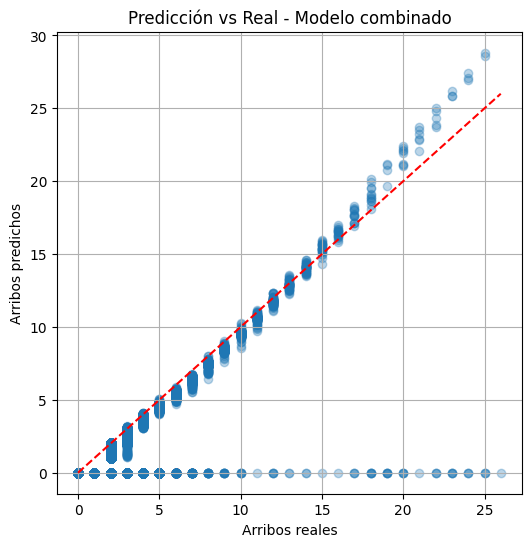

In [65]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.scatter(y_test_reg, y_pred_combined, alpha=0.3)
plt.plot([0, max(y_test_reg)], [0, max(y_test_reg)], color='red', linestyle='--')
plt.xlabel("Arribos reales")
plt.ylabel("Arribos predichos")
plt.title("Predicción vs Real - Modelo combinado")
plt.grid(True)
plt.show()



In [77]:
# Paso 2: Armar DataFrame de resultados
df_eval = X_test.copy()
df_eval["y_real"] = y_test_reg
df_eval["y_pred"] = y_pred_combined
df_eval["error_abs"] = np.abs(df_eval["y_real"] - df_eval["y_pred"])
df_eval["error_signed"] = df_eval["y_pred"] - df_eval["y_real"]

# (opcional) Mapear estación a nombre
if "id_estacion" in df_eval.columns:
    nombres = dataset[["id_estacion", "nombre_estacion"]].drop_duplicates()
    df_eval = df_eval.merge(nombres, on="id_estacion", how="left")

# Guardar DataFrame de evaluación
df_eval.to_csv("data/streamlit/evaluacion_modelo_combinado.csv", index=False)

In [78]:
print(X_test.shape)

(877133, 23)


In [67]:
import joblib
import torch

# Crear carpeta si no existe
import os
os.makedirs("models", exist_ok=True)

# Guardar modelo PyTorch (solo pesos)
torch.save(reg_model.state_dict(), "models/mlp_tree.pth")

# Guardar preprocessor de sklearn
joblib.dump(preprocessor, "models/preprocessor_mlp_tree.pkl")

# Guardar clasificador
joblib.dump(clf_model, "models/clf_model.pkl")

# Guardar metadatos
model_metadata = {
    "input_dim": X_train_tensor.shape[1],
    "num_stations": len(station_mapping),
    "emb_dim": 8,
    "station_mapping": station_mapping
}
joblib.dump(model_metadata, "models/model_metadata_mlp_tree.pkl")

print("✅ Modelos y preprocesadores guardados correctamente.")


✅ Modelos y preprocesadores guardados correctamente.


In [ ]:
import mlflow
import torch
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA

import mlflow.pytorch

# Configurar el experimento
mlflow.set_experiment("modelo_bicis_gcba_mlp")

print("\n📊 REGISTRANDO RESULTADOS DE MLP + EMBEDDING EN MLFLOW...")

with mlflow.start_run(run_name="MLP_with_Embeddings"):
    # Registrar hiperparámetros del modelo
    mlflow.log_params({
        "model_type": "MLP_with_Embeddings",
        "embedding_dim": 8,
        "hidden_layer_1": 128,
        "hidden_layer_2": 64,
        "learning_rate": 1e-3,
        "batch_size": 64,
        "epochs": n_epochs,
        "dropout_1": 0.2,
        "dropout_2": 0.1
    })
    
    # Registrar métricas de evaluación
    mlflow.log_metrics({
        "mae": mae,
        "rmse": rmse,
        "r2": r2
    })
    
    # Guardar el modelo PyTorch
    mlflow.pytorch.log_model(model, "mlp_embedding_model")
    
    # Crear y guardar gráfico de importancia de embeddings (opcional)
    if hasattr(model, 'embedding'):
        try:
            # Extraer y analizar los embeddings de estaciones
            embeddings = model.embedding.weight.data.cpu().numpy()
            
            # Crear un DataFrame con la norma de cada embedding
            embedding_importance = pd.DataFrame({
                'station_id': list(station_mapping.keys()),
                'embedding_norm': np.linalg.norm(embeddings, axis=1)
            }).sort_values('embedding_norm', descending=True)
            
            # Guardar como CSV
            embedding_csv_path = "station_embeddings.csv"
            embedding_importance.to_csv(embedding_csv_path, index=False)
            mlflow.log_artifact(embedding_csv_path)
            
            # Opcional: visualizar algunos embeddings con PCA
            import matplotlib.pyplot as plt
            
            # Aplicar PCA para visualización 2D
            pca = PCA(n_components=2)
            embeddings_2d = pca.fit_transform(embeddings)
            
            # Crear gráfico de dispersión de embeddings
            plt.figure(figsize=(10, 8))
            plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.5)
            
            # Etiquetar algunos puntos (opcional)
            top_stations = embedding_importance.head(10)['station_id'].values
            for station_id in top_stations:
                station_idx = station_mapping[station_id]
                x, y = embeddings_2d[station_idx]
                plt.annotate(f"Est.{station_id}", (x, y), fontsize=9)
            
            plt.title('Visualización 2D de Embeddings de Estaciones (PCA)')
            plt.xlabel('Componente 1')
            plt.ylabel('Componente 2')
            plt.grid(alpha=0.3)
            
            # Guardar la figura
            embedding_plot_path = "station_embeddings_pca.png"
            plt.savefig(embedding_plot_path)
            mlflow.log_artifact(embedding_plot_path)
            plt.close()
            
        except Exception as e:
            print(f"No se pudo guardar visualización de embeddings: {e}")
    
    print("✅ Modelo MLP con Embeddings registrado en MLflow")

2025/06/07 21:37:36 INFO mlflow.tracking.fluent: Experiment with name 'modelo_bicis_gcba_mlp' does not exist. Creating a new experiment.



📊 REGISTRANDO RESULTADOS DE MLP + EMBEDDING EN MLFLOW...


2025/06/07 21:37:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


No se pudo guardar visualización de embeddings: DataFrame.sort_values() got an unexpected keyword argument 'descending'
✅ Modelo MLP con Embeddings registrado en MLflow


In [86]:
print("\n✂️ DIVIDIENDO DATOS TEMPORALMENTE...")

# Split temporal: últimas 2 semanas para test
cutoff_date = dataset_clean['timestamp'].max() - timedelta(weeks=8)

train_data = dataset_clean[dataset_clean['timestamp'] <= cutoff_date]
test_data = dataset_clean[dataset_clean['timestamp'] > cutoff_date]

print(f"📅 Split temporal:")
print(f"   - Train: {len(train_data)} registros (hasta {cutoff_date.strftime('%Y-%m-%d')})")
print(f"   - Test: {len(test_data)} registros (desde {cutoff_date.strftime('%Y-%m-%d')})")

# Preparar X y y
X_train = train_data[feature_columns]
y_train = train_data['target']
X_test = test_data[feature_columns]
y_test = test_data['target']
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)
y_train = y_train_log
y_test = y_test_log

print(f"✅ Datos preparados para entrenamiento")


✂️ DIVIDIENDO DATOS TEMPORALMENTE...
📅 Split temporal:
   - Train: 3374976 registros (hasta 2024-07-05)
   - Test: 1010688 registros (desde 2024-07-05)
✅ Datos preparados para entrenamiento


In [87]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import numpy as np
import pandas as pd

print("\n🌲 ENTRENANDO RANDOM FOREST y XGBOOST...")

# ========== 🔧 Preparación de datos ==========
# df = pd.read_csv(...)  # Asumimos que ya lo tenés

# X = df.drop(columns=['target', 'timestamp', 'nombre_estacion'])
y = dataset_clean['target']

categorical_cols = ['id_estacion', 'hora', 'dia_semana', 'mes']
numerical_cols = [col for col in X_train.columns if col not in categorical_cols]

# ========== 🧠 Modelos ==========
models = {
    'Random Forest': RandomForestRegressor(
        n_estimators=100, max_depth=10, random_state=42, n_jobs=-1
    ),
    'XGBoost': XGBRegressor(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        random_state=42,
        verbosity=0,
        tree_method="gpu_hist",        # ⚡️ usa GPU
        predictor="gpu_predictor"
    )
}

results = {}

# ========== 🔁 Entrenamiento por modelo ==========
for name, model in models.items():
    print(f"\n🔄 Entrenando {name}...")

    # Preprocesamiento: one-hot para categóricas
    preprocessor = ColumnTransformer(transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
        ('num', 'passthrough', numerical_cols)
    ])

    pipeline = Pipeline(steps=[
        ('preprocessing', preprocessor),
        ('model', model)
    ])

    pipeline.fit(X_train, y_train)
    pred_log = pipeline.predict(X_test)
    y_pred = np.expm1(pred_log)

    # Evaluación
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    results[name] = {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2,
        'model': pipeline,
        'predictions': y_pred
    }

    print(f"✅ {name} - MAE: {mae:.3f}, RMSE: {rmse:.3f}, R2: {r2:.3f}")



🌲 ENTRENANDO RANDOM FOREST y XGBOOST...

🔄 Entrenando Random Forest...
✅ Random Forest - MAE: 0.281, RMSE: 0.428, R2: 0.044

🔄 Entrenando XGBoost...
✅ XGBoost - MAE: 0.280, RMSE: 0.427, R2: 0.047


In [81]:
print(X_train, X_test, y_train, y_test)

         id_estacion  partidas  hora  dia_semana  es_fin_de_semana  mes  dia  \
0                  2       0.0     0           0                 0    1    1   
1                  2       0.0     0           0                 0    1    1   
2                  2       0.0     1           0                 0    1    1   
3                  2       0.0     1           0                 0    1    1   
4                  2       0.0     2           0                 0    1    1   
...              ...       ...   ...         ...               ...  ...  ...   
3508526          476       0.0     7           5                 1    7   13   
3508527          476       0.0     7           5                 1    7   13   
3508528          476       0.0     8           5                 1    7   13   
3508529          476       0.0     8           5                 1    7   13   
3508530          476       0.0     9           5                 1    7   13   

         arribos  lat_estacion  long_es

In [ ]:
import mlflow
import mlflow.sklearn
from datetime import datetime
import os

# Inicializar MLflow (puede ser local o remoto)
# mlflow.set_tracking_uri("file:./mlruns")  # o usar URL de servidor si tenés uno
mlflow.set_experiment("modelo_bicis_gcba")

# Guardar cada modelo
for name, result in results.items():
    print(f"\n📦 Guardando en MLflow: {name}")
    with mlflow.start_run(run_name=name):

        # Métricas
        mlflow.log_metric("MAE", result['MAE'])
        mlflow.log_metric("MSE", result['MSE'])
        mlflow.log_metric("RMSE", result['RMSE'])
        mlflow.log_metric("R2", result['R2'])

        # Tags opcionales
        mlflow.set_tag("modelo", name)
        mlflow.set_tag("timestamp", str(datetime.now()))
        mlflow.set_tag("autor", "Matteo Musacchio")

        # Guardar modelo (pickleado automáticamente)
        mlflow.sklearn.log_model(result['model'], artifact_path="modelo_entrenado")

        # Opcional: guardar predicciones
        pred_df = pd.DataFrame({
            "y_real": y_test,
            "y_pred": result['predictions']
        })
        pred_csv_path = f"predicciones_{name.replace(' ', '_')}.csv"
        pred_df.to_csv(pred_csv_path, index=False)
        mlflow.log_artifact(pred_csv_path)

        # Limpieza temporal
        os.remove(pred_csv_path)


PASO 12: ENTRENAMIENTO DE MODELOS

In [ ]:
import tqdm
# import XGBoost sklearn

print("\n🤖 ENTRENANDO MODELOS...")

# Diccionario de modelos a probar
models = {
    'Random Forest': RandomForestRegressor(n_estimators=100,max_depth=10, random_state=42),

}

# Entrenar y evaluar cada modelo
results = {}

for name, model in models.items():
    print(f"\n🔄 Entrenando {name}...")
    
    # Entrenar modelo
    if name in ['Ridge Regression', 'Lasso Regression']:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    
    # Calcular métricas
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    results[name] = {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2,
        'model': model,
        'predictions': y_pred
    }
    
    print(f"   ✅ {name} - MAE: {mae:.3f}, RMSE: {rmse:.3f}, R2: {r2:.3f}")



🤖 ENTRENANDO MODELOS...

🔄 Entrenando Random Forest...
   ✅ Random Forest - MAE: 0.473, RMSE: 0.816, R2: 0.320


PASO 13: EVALUACIÓN Y COMPARACIÓN DE MODELOS

In [ ]:

print("\n📊 RESUMEN DE RESULTADOS:")
print("="*60)

results_df = pd.DataFrame({
    name: {metric: results[name][metric] for metric in ['MAE', 'RMSE', 'R2']}
    for name in results.keys()
}).round(3)

print(results_df)

# Encontrar el mejor modelo
best_model_name = min(results.keys(), key=lambda x: results[x]['MAE'])
best_model = results[best_model_name]['model']

print(f"\n🏆 MEJOR MODELO: {best_model_name}")
print(f"   - MAE: {results[best_model_name]['MAE']:.3f}")
print(f"   - RMSE: {results[best_model_name]['RMSE']:.3f}")
print(f"   - R2: {results[best_model_name]['R2']:.3f}")


📊 RESUMEN DE RESULTADOS:
      Random Forest
MAE           0.473
RMSE          0.816
R2            0.320

🏆 MEJOR MODELO: Random Forest
   - MAE: 0.473
   - RMSE: 0.816
   - R2: 0.320


In [ ]:
# Guardar resultados en MLflow
import mlflow
import mlflow.sklearn

print("\n📝 REGISTRANDO RESULTADOS EN MLFLOW...")

# Iniciar experimento de MLflow
mlflow.set_experiment("Random Forest Predicción Arribos")

with mlflow.start_run(run_name="Random Forest Base"):
    
    # Registrar hiperparámetros del Random Forest
    rf_params = best_model.get_params()
    mlflow.log_params(rf_params)
    
    # Registrar métricas principales
    mlflow.log_metrics({
        "mae": results["Random Forest"]['MAE'],
        "rmse": results["Random Forest"]['RMSE'], 
        "r2": results["Random Forest"]['R2']
    })
    
    # Registrar métricas adicionales
    y_pred_rf = results["Random Forest"]['predictions']
    mlflow.log_metric("mse", mean_squared_error(y_test, y_pred_rf))
    
    # Guardar el modelo
    mlflow.sklearn.log_model(best_model, "random_forest_model")
    
    # Registrar feature importances como artefacto
    if hasattr(best_model, 'feature_importances_'):
        feature_imp_df = pd.DataFrame({
            'feature': feature_columns,
            'importance': best_model.feature_importances_
        }).sort_values('importance', ascending=False)
        
        # Guardar CSV con importancia de features
        feature_imp_df.to_csv("feature_importances.csv", index=False)
        mlflow.log_artifact("feature_importances.csv")

print("✅ Resultados guardados exitosamente en MLflow")


2025/06/07 17:44:35 INFO mlflow.tracking.fluent: Experiment with name 'Random Forest Predicción Arribos' does not exist. Creating a new experiment.



📝 REGISTRANDO RESULTADOS EN MLFLOW...


2025/06/07 17:44:39 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\Matteo\AppData\Local\Temp\tmp5pc2zw80\model\model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.3.0', 'cloudpickle==3.1.1']. Set logging level to DEBUG to see the full traceback. 
2025/06/07 17:44:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ Resultados guardados exitosamente en MLflow


PASO 14: ANÁLISIS DE IMPORTANCIA DE FEATURES

In [ ]:

print("\n🎯 ANÁLISIS DE IMPORTANCIA DE FEATURES...")

if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': feature_columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("\nTop 10 features más importantes:")
    print(feature_importance.head(10))
    
elif hasattr(best_model, 'coef_'):
    feature_importance = pd.DataFrame({
        'feature': feature_columns,
        'coefficient': abs(best_model.coef_)
    }).sort_values('coefficient', ascending=False)
    
    print("\nTop 10 features con mayores coeficientes:")
    print(feature_importance.head(10))


🎯 ANÁLISIS DE IMPORTANCIA DE FEATURES...

Top 10 features más importantes:
                    feature  importance
14   partidas_rolling_sum_6    0.650891
13  partidas_rolling_mean_3    0.116233
0                      hora    0.108226
6             long_estacion    0.035692
5              lat_estacion    0.034297
7       distancia_al_centro    0.021183
16          usuarios_unicos    0.008504
1                dia_semana    0.007379
2          es_fin_de_semana    0.006999
12           partidas_lag_6    0.003161


PASO 15: VALIDACIÓN CON SERIES TEMPORALES

In [ ]:

print("\n📈 VALIDACIÓN CON TIME SERIES SPLIT...")

# Usar TimeSeriesSplit para validación más robusta
tscv = TimeSeriesSplit(n_splits=5)
cv_scores = []

# Preparar datos ordenados por tiempo para CV
train_data_sorted = train_data.sort_values('timestamp')
X_cv = train_data_sorted[feature_columns]
y_cv = train_data_sorted['target']

# Validación cruzada temporal
for fold, (train_idx, val_idx) in enumerate(tscv.split(X_cv)):
    X_train_cv, X_val_cv = X_cv.iloc[train_idx], X_cv.iloc[val_idx]
    y_train_cv, y_val_cv = y_cv.iloc[train_idx], y_cv.iloc[val_idx]
    
    # Entrenar modelo del best performer
    if best_model_name in ['Ridge Regression', 'Lasso Regression']:
        X_train_cv_scaled = scaler.fit_transform(X_train_cv)
        X_val_cv_scaled = scaler.transform(X_val_cv)
        temp_model = type(best_model)(**best_model.get_params())
        temp_model.fit(X_train_cv_scaled, y_train_cv)
        y_pred_cv = temp_model.predict(X_val_cv_scaled)
    else:
        temp_model = type(best_model)(**best_model.get_params())
        temp_model.fit(X_train_cv, y_train_cv)
        y_pred_cv = temp_model.predict(X_val_cv)
    
    mae_cv = mean_absolute_error(y_val_cv, y_pred_cv)
    cv_scores.append(mae_cv)
    
    print(f"   Fold {fold+1}: MAE = {mae_cv:.3f}")

print(f"\n✅ Validación cruzada completada:")
print(f"   - MAE promedio: {np.mean(cv_scores):.3f} (±{np.std(cv_scores):.3f})")


📈 VALIDACIÓN CON TIME SERIES SPLIT...
   Fold 1: MAE = 0.566
   Fold 2: MAE = 0.548


KeyboardInterrupt: 

PASO 16: FUNCIÓN DE PREDICCIÓN

In [ ]:

print("\n🔮 CREANDO FUNCIÓN DE PREDICCIÓN...")

def predecir_arribos_futuro(timestamp_inicio, estaciones_partidas, modelo=best_model, 
                           scaler_obj=scaler, usar_escalado=best_model_name in ['Ridge Regression', 'Lasso Regression']):
    """
    Predice arribos de bicicletas para todas las estaciones en los próximos 30 minutos
    
    Parameters:
    timestamp_inicio: datetime - momento desde el cual predecir
    estaciones_partidas: dict - {id_estacion: cantidad_partidas} en últimos 30 min
    """
    
    predicciones = {}
    
    for id_estacion in todas_las_estaciones['id_estacion'].unique():
        # Obtener info de la estación
        estacion_info = todas_las_estaciones[todas_las_estaciones['id_estacion'] == id_estacion].iloc[0]
        
        # Crear features para la predicción
        features = {
            'hora': timestamp_inicio.hour,
            'dia_semana': timestamp_inicio.weekday(),
            'es_fin_de_semana': 1 if timestamp_inicio.weekday() >= 5 else 0,
            'mes': timestamp_inicio.month,
            'dia': timestamp_inicio.day,
            'lat_estacion': estacion_info['lat_estacion'],
            'long_estacion': estacion_info['long_estacion'],
            'distancia_al_centro': np.sqrt((estacion_info['lat_estacion'] - centro_lat)**2 + 
                                         (estacion_info['long_estacion'] - centro_long)**2),
            'partidas': estaciones_partidas.get(id_estacion, 0),
            'partidas_lag_1': 0,  # Simplificado para el ejemplo
            'partidas_lag_2': 0,
            'partidas_lag_3': 0,
            'partidas_lag_6': 0,
            'partidas_rolling_mean_3': estaciones_partidas.get(id_estacion, 0),
            'partidas_rolling_sum_6': estaciones_partidas.get(id_estacion, 0)
        }
        
        # Agregar features de usuario si existen
        if 'total_viajes_usuarios' in feature_columns:
            features['total_viajes_usuarios'] = estaciones_partidas.get(id_estacion, 0)
            features['usuarios_unicos'] = min(estaciones_partidas.get(id_estacion, 0), 1)
        
        # Convertir a array para predicción
        X_pred = np.array([[features[col] for col in feature_columns]])
        
        # Hacer predicción
        if usar_escalado:
            X_pred_scaled = scaler_obj.transform(X_pred)
            pred = modelo.predict(X_pred_scaled)[0]
        else:
            pred = modelo.predict(X_pred)[0]
        
        predicciones[id_estacion] = max(0, round(pred))  # No puede ser negativo
    
    return predicciones

print("✅ Función de predicción creada")



🔮 CREANDO FUNCIÓN DE PREDICCIÓN...
✅ Función de predicción creada


PASO 17: EJEMPLO DE USO

In [ ]:

print("\n🧪 EJEMPLO DE PREDICCIÓN...")

# Crear un ejemplo de partidas por estación en los últimos 30 min
ejemplo_timestamp = datetime(2024, 8, 15, 14, 30)  # Ejemplo: 15 de agosto 2024, 14:30
ejemplo_partidas = {
    list(todas_las_estaciones['id_estacion'])[0]: 5,
    list(todas_las_estaciones['id_estacion'])[1]: 3,
    list(todas_las_estaciones['id_estacion'])[2]: 8,
    # Resto con 0 partidas
}

# Completar con 0s para todas las estaciones
for id_est in todas_las_estaciones['id_estacion']:
    if id_est not in ejemplo_partidas:
        ejemplo_partidas[id_est] = 0

# Hacer predicción
predicciones_ejemplo = predecir_arribos_futuro(ejemplo_timestamp, ejemplo_partidas)

print(f"🎯 Predicción para {ejemplo_timestamp.strftime('%Y-%m-%d %H:%M')}:")
print("Top 10 estaciones con más arribos predichos:")

# Mostrar top 10 predicciones
pred_sorted = sorted(predicciones_ejemplo.items(), key=lambda x: x[1], reverse=True)
for i, (id_estacion, arribos) in enumerate(pred_sorted[:10]):
    nombre = todas_las_estaciones[todas_las_estaciones['id_estacion']==id_estacion]['nombre_estacion'].iloc[0]
    print(f"   {i+1}. Estación {id_estacion} ({nombre[:30]}...): {arribos} arribos")


🧪 EJEMPLO DE PREDICCIÓN...
🎯 Predicción para 2024-08-15 14:30:
Top 10 estaciones con más arribos predichos:
   1. Estación 467 (328 - SARMIENTO II...): 2 arribos
   2. Estación 513 (308 - SAN MARTIN II...): 1 arribos
   3. Estación 163 (163 - ONCE II...): 1 arribos
   4. Estación 165 (165 - PLAZA MONSEÑOR MIGUEL DE...): 1 arribos
   5. Estación 144 (144 - PUEYRREDÓN...): 1 arribos
   6. Estación 85 (085 - AGUERO...): 1 arribos
   7. Estación 460 (133 - BEIRO Y SEGUROLA...): 0 arribos
   8. Estación 382 (204 - Biarritz...): 0 arribos
   9. Estación 137 (137 - AZOPARDO Y CHILE...): 0 arribos
   10. Estación 99 (099 - Malabia...): 0 arribos


PASO 18: ANÁLISIS DE PATRONES TEMPORALES

In [ ]:

print("\n📊 ANÁLISIS DE PATRONES TEMPORALES...")

# Análisis por hora del día
patron_hora = dataset_clean.groupby('hora')['target'].mean()
print("\nPromedio de arribos por hora del día:")
for hora, arribos in patron_hora.items():
    print(f"   {hora:02d}:00 - {arribos:.1f} arribos promedio")

# Análisis por día de la semana
dias_semana = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']
patron_dia = dataset_clean.groupby('dia_semana')['target'].mean()
print("\nPromedio de arribos por día de la semana:")
for dia_num, arribos in patron_dia.items():
    print(f"   {dias_semana[dia_num]}: {arribos:.1f} arribos promedio")


📊 ANÁLISIS DE PATRONES TEMPORALES...

Promedio de arribos por hora del día:
   00:00 - 0.2 arribos promedio
   01:00 - 0.1 arribos promedio
   02:00 - 0.1 arribos promedio
   03:00 - 0.1 arribos promedio
   04:00 - 0.1 arribos promedio
   05:00 - 0.1 arribos promedio
   06:00 - 0.3 arribos promedio
   07:00 - 0.5 arribos promedio
   08:00 - 0.5 arribos promedio
   09:00 - 0.4 arribos promedio
   10:00 - 0.4 arribos promedio
   11:00 - 0.5 arribos promedio
   12:00 - 0.7 arribos promedio
   13:00 - 0.7 arribos promedio
   14:00 - 0.7 arribos promedio
   15:00 - 0.9 arribos promedio
   16:00 - 1.0 arribos promedio
   17:00 - 1.1 arribos promedio
   18:00 - 1.0 arribos promedio
   19:00 - 0.8 arribos promedio
   20:00 - 0.6 arribos promedio
   21:00 - 0.4 arribos promedio
   22:00 - 0.3 arribos promedio
   23:00 - 0.2 arribos promedio

Promedio de arribos por día de la semana:
   Lunes: 0.6 arribos promedio
   Martes: 0.6 arribos promedio
   Miércoles: 0.6 arribos promedio
   Jueves: 0.6

PASO 19: MÉTRICAS DE NEGOCIO

In [ ]:

print("\n💼 MÉTRICAS DE NEGOCIO...")

# Calcular precisión en predicción de alta demanda (top 20% de arribos)
threshold_alta_demanda = y_test.quantile(0.8)
y_test_alta = (y_test >= threshold_alta_demanda).astype(int)
y_pred_best = results[best_model_name]['predictions']
y_pred_alta = (y_pred_best >= threshold_alta_demanda).astype(int)

from sklearn.metrics import precision_score, recall_score, f1_score

precision_alta = precision_score(y_test_alta, y_pred_alta, zero_division=0)
recall_alta = recall_score(y_test_alta, y_pred_alta, zero_division=0)
f1_alta = f1_score(y_test_alta, y_pred_alta, zero_division=0)

print(f"📈 Predicción de alta demanda (top 20%):")
print(f"   - Precision: {precision_alta:.3f}")
print(f"   - Recall: {recall_alta:.3f}")
print(f"   - F1-Score: {f1_alta:.3f}")

# Error relativo promedio
error_relativo = abs(y_test - y_pred_best) / (y_test + 1)  # +1 para evitar división por 0
print(f"\n📊 Error relativo promedio: {error_relativo.mean():.1%}")


💼 MÉTRICAS DE NEGOCIO...
📈 Predicción de alta demanda (top 20%):
   - Precision: 0.693
   - Recall: 0.368
   - F1-Score: 0.481

📊 Error relativo promedio: 30.5%


PASO 20: CONCLUSIONES Y PRÓXIMOS PASOS

In [ ]:

print("\n" + "="*80)
print("🎉 RESUMEN FINAL DEL PROYECTO")
print("="*80)

print(f"\n📊 DATASET PROCESADO:")
print(f"   - Registros totales procesados: {len(dataset_clean):,}")
print(f"   - Estaciones monitoreadas: {todas_las_estaciones['id_estacion'].nunique()}")
print(f"   - Ventanas temporales de: {DELTA_T_MINUTES} minutos")
print(f"   - Período analizado: {trips_df['fecha_origen_recorrido'].min().strftime('%Y-%m-%d')} a {trips_df['fecha_origen_recorrido'].max().strftime('%Y-%m-%d')}")

print(f"\n🤖 MEJOR MODELO: {best_model_name}")
print(f"   - Error absoluto medio: {results[best_model_name]['MAE']:.2f} arribos")
print(f"   - Error cuadrático medio: {results[best_model_name]['RMSE']:.2f} arribos")
print(f"   - R² Score: {results[best_model_name]['R2']:.3f}")
print(f"   - Error relativo promedio: {error_relativo.mean():.1%}")

print(f"\n🎯 APLICACIONES PRÁCTICAS:")
print(f"   - Redistribución proactiva de bicicletas")
print(f"   - Optimización de recursos de mantenimiento")
print(f"   - Planificación de capacidad por estación")
print(f"   - Alertas tempranas de alta/baja demanda")

print(f"\n🔮 PREDICCIÓN EJEMPLO:")
print(f"   - Para el {ejemplo_timestamp.strftime('%Y-%m-%d %H:%M')}")
print(f"   - Total arribos predichos: {sum(predicciones_ejemplo.values())} bicicletas")
print(f"   - Estación con mayor demanda predicha: {max(predicciones_ejemplo.values())} arribos")

print(f"\n📈 PRÓXIMOS PASOS RECOMENDADOS:")
print(f"   1. Implementar modelos más sofisticados (LSTM, XGBoost)")
print(f"   2. Incluir datos meteorológicos y eventos especiales")
print(f"   3. Desarrollar API para predicciones en tiempo real")
print(f"   4. Crear dashboard de monitoreo operativo")
print(f"   5. Validar con datos de septiembre 2024 en adelante")

print("\n🚴 ¡PROYECTO COMPLETADO EXITOSAMENTE! 🚴")
print("="*80)


🎉 RESUMEN FINAL DEL PROYECTO

📊 DATASET PROCESADO:
   - Registros totales procesados: 4,383,032
   - Estaciones monitoreadas: 376
   - Ventanas temporales de: 30 minutos
   - Período analizado: 2024-01-01 a 2024-08-30

🤖 MEJOR MODELO: Random Forest
   - Error absoluto medio: 0.47 arribos
   - Error cuadrático medio: 0.82 arribos
   - R² Score: 0.320
   - Error relativo promedio: 30.5%

🎯 APLICACIONES PRÁCTICAS:
   - Redistribución proactiva de bicicletas
   - Optimización de recursos de mantenimiento
   - Planificación de capacidad por estación
   - Alertas tempranas de alta/baja demanda

🔮 PREDICCIÓN EJEMPLO:
   - Para el 2024-08-15 14:30
   - Total arribos predichos: 7 bicicletas
   - Estación con mayor demanda predicha: 2 arribos

📈 PRÓXIMOS PASOS RECOMENDADOS:
   1. Implementar modelos más sofisticados (LSTM, XGBoost)
   2. Incluir datos meteorológicos y eventos especiales
   3. Desarrollar API para predicciones en tiempo real
   4. Crear dashboard de monitoreo operativo
   5. Val

In [ ]:

print("\n💾 GUARDANDO MODELOS Y DATOS PARA DASHBOARD...")

# Crear directorio para modelos si no existe
import os
if not os.path.exists('models'):
    os.makedirs('models')

if not os.path.exists('data/streamlit'):
    os.makedirs('data/streamlit')

# Guardar el mejor modelo
import joblib
model_filename = f'models/best_model_{best_model_name.replace(" ", "_").lower()}.joblib'
joblib.dump(best_model, model_filename)
print(f"✅ Modelo guardado en: {model_filename}")

# Guardar el scaler
scaler_filename = 'models/scaler.joblib'
joblib.dump(scaler, scaler_filename)
print(f"✅ Scaler guardado en: {scaler_filename}")

# Guardar metadatos del modelo
model_metadata = {
    'mejor_modelo': best_model_name,
    'usar_escalado': best_model_name in ['Ridge Regression', 'Lasso Regression'],
    'feature_columns': feature_columns,
    'resultados_modelos': results,
    'centro_lat': centro_lat,
    'centro_long': centro_long,
    'delta_t_minutes': DELTA_T_MINUTES
}

import pickle
with open('models/model_metadata.pkl', 'wb') as f:
    pickle.dump(model_metadata, f)
print(f"✅ Metadatos guardados en: models/model_metadata.pkl")

# Guardar dataset procesado (una muestra para el dashboard)
dataset_sample = dataset_clean  # Últimos 1000 registros
dataset_sample.to_csv('data/streamlit/dataset_sample.csv', index=False)
print(f"✅ Dataset sample guardado en: data/streamlit/dataset_sample.csv")

# Guardar estaciones
todas_las_estaciones.to_csv('data/streamlit/estaciones.csv', index=False)
print(f"✅ Estaciones guardadas en: data/streamlit/estaciones.csv")

# Guardar datos históricos agregados para análisis temporal
datos_historicos_dashboard = dataset_clean.groupby(['timestamp', 'hora', 'dia_semana', 'es_fin_de_semana']).agg({
    'partidas': 'sum',
    'arribos': 'sum',
    'target': 'sum'
}).reset_index()

datos_historicos_dashboard.to_csv('data/streamlit/datos_historicos.csv', index=False)
print(f"✅ Datos históricos guardados en: data/streamlit/datos_historicos.csv")

print(f"\n🎉 ARCHIVOS LISTOS PARA EL DASHBOARD:")
print(f"   📁 models/")
print(f"   📁 data/streamlit/")
print(f"\n💡 Ahora puedes ejecutar el dashboard con datos reales!")


💾 GUARDANDO MODELOS Y DATOS PARA DASHBOARD...
✅ Modelo guardado en: models/best_model_random_forest.joblib
✅ Scaler guardado en: models/scaler.joblib
✅ Metadatos guardados en: models/model_metadata.pkl
✅ Dataset sample guardado en: data/streamlit/dataset_sample.csv
✅ Estaciones guardadas en: data/streamlit/estaciones.csv
✅ Datos históricos guardados en: data/streamlit/datos_historicos.csv

🎉 ARCHIVOS LISTOS PARA EL DASHBOARD:
   📁 models/
   📁 data/streamlit/

💡 Ahora puedes ejecutar el dashboard con datos reales!
